# Lectura de firmas desde xlsx

Fecha: 16 de julio de 2023

mail: taveiragerman@gmail.com

---

### Descripción

Este notebook contiene el proceso para abrir y visualizar las firmas guardadas en xlsx en la notebook de procesamiento de .sig.

### Contenido
Se cargaran los datos de firmas promediadas desde archivos de Excel, se realiza el procesamiento necesario y se generarán visualizaciones de las firmas.

---


## Configuración de la Notebook

Esta celda de código importa las siguientes bibliotecas y módulos necesarios para el procesamiento de datos en tu notebook de Jupyter:

datetime, timedelta y date del módulo datetime: Estos módulos proporcionan clases y funciones para trabajar con fechas, horas y duraciones. Se utilizan para manipular y calcular fechas en el código.

pandas como pd: Pandas es una biblioteca popular para el análisis y manipulación de datos. Se utiliza para abrir archivos CSV y trabajar con estructuras de datos tabulares, como DataFrames.

functions: Se importan las funciones definidas en un archivo llamado "functions.py". Es importante destacar que este archivo debe estar ubicado en la misma carpeta que la notebook para que pueda ser importado correctamente.

In [12]:
from datetime import datetime, timedelta, date 
import pandas as pd 
from functions import * 

Se definen las rutas:

path_2022: Es la ruta del archivo Excel que contiene las firmas espectrales promedio de cebada para el año 2022. Esta ruta debe apuntar a la carpeta de trabajo donde se encuentran las carpetas con los archivos .sig y las tablas de campo.

path_out: Es la ruta de la carpeta de salida donde se guardarán los archivos generados.

In [15]:
# Seteo de las rutas
path = './output/firmas_cebada_promedio_2022.xlsx'

path_out = './output/'

## Recuperación las firmas del Excel

Esta función toma como entrada la ruta del archivo de Excel (path) que contiene las firmas y sus metadatos en hojas separadas. La función lee el archivo de Excel utilizando pd.read_excel() y almacena cada hoja en un diccionario.

Luego, se procesa cada hoja individualmente. Se identifica el índice donde comienza la tabla de datos y se extraen tanto la metadata como los datos correspondientes a cada hoja. La metadata se guarda en un diccionario donde cada clave es el nombre de la columna de metadata y el valor es el valor correspondiente.

Se renombran las columnas del dataframe de datos (data) para tener nombres más descriptivos ('longitud_onda', 'radiancia', 'target', 'reflectancia'). Luego, se crea un nuevo diccionario (firma) para almacenar tanto la metadata como los datos. La metadata se agrega como claves y valores al diccionario firma, y los datos se guardan en la clave 'data'.

Finalmente, todos los diccionarios de firmas se agregan a una lista (firmas), que se devuelve como resultado de la función.

In [3]:
# Recupero las firmas de los excel

def from_excel_to_dic(path):

    # Abro el excel con todas las firmas
    dic = pd.read_excel(path, sheet_name=None)
    # Se pone cada hoja en un diccionario
    sheet_names = list(dict.fromkeys(dic))

    firmas = []
    for sheet in sheet_names:
        # Recupero el índice donde inicia la tabla de datos
        index_data = dic[sheet].loc[(dic[sheet].metadata_item == 'longitud_onda')].index[0]
        # Recupero la metadata y los datos de cada hoja de excel
        metadata = dic[sheet][:index_data-2]
        data = dic[sheet][index_data+1:]

        metadata  = metadata[['metadata_item','value']]

        # Renombro las columnas del dataframe de 'data'
        columnas = ['longitud_onda','radiancia','target','reflectancia']
        # data.set_axis(columnas, axis=1, inplace=True)
        data.columns = columnas
        data = data.reset_index()
        data = data[columnas]

        # Genero un nuevo diccionario para cada dato y meta
        firma = {}
        for i in range(len(metadata)-1):
            key = metadata.iloc[[i]].metadata_item.values[0]
            value = metadata.iloc[[i]].value.values[0]
            firma[key] = value

        firma['data'] =  data  

        # Uno todos los diccionarios en una lista
        firmas.append(firma)

    return firmas

In [16]:
# Genero las firmas
firmas = from_excel_to_dic(path= path)

## Estructura de los datos

La variable 'firmas' es la lista de diccionarios que contiene cada firma.

Para listar el contenido de cada firma, se itera sobre las claves del primer diccionario en la lista y se imprime el nombre de cada clave.

In [25]:
# Las firmas ahora están en diccionarios agrupados en una lista.

# Es posible listar lo que contiene cada firma (diccionario):
for key in firmas[0].keys():
    print(key)

instrument
integration
scan method
scan coadds
scan time
scan settings
external data mask
optic
units
time
longitude
latitude
gpstime
factors
date_radiancia
date_target
date_dt
time_target
id_date
n_firma
zona
nombre_zona
distancia
cobertura
id_firma
coordenadas_radiancia
coordenadas_target
id_units
data


Para acceder a un valor específico, se utiliza la sintaxis diccionario['clave'] para acceder al valor asociado a una clave específica en el primer diccionario de la lista. En este ejemplo, se muestra el valor de 'id_firma' y 'coordenadas_target'.


In [26]:
print('id_firma:',firmas[0]['id_firma'],
      '\nCoordenadas del target:', firmas[0]['coordenadas_target'])

id_firma: 20220819_1_1 
Coordenadas del target: [-58.909013333333334, -37.483603]


Para ver los valores de radiación de la primera firma, se accede a la clave 'data' del primer diccionario en la lista y se utiliza el método head(3) para mostrar las primeras 3 filas de los datos de radiación.

In [27]:
# Por ejemplo, para ver los valores de radiación de la primera firma se puede:
firmas[0]['data'].head(3)

,longitud_onda,radiancia,target,reflectancia
0,338.5,78.50827,2.502857,3.19
1,340,83.5085,2.65445,3.18
2,341.5,84.55168,2.674437,3.163333


## Ejemplos:

### Recuento de firmas

Esta función toma como entrada una lista de diccionarios de firmas firmas_list y agrupa las firmas por fecha en un diccionario dic_firmas_por_fecha. Cada clave del diccionario es una fecha y su valor correspondiente es una lista de todas las firmas asociadas a esa fecha.

Dentro del bucle for, se extrae la fecha de cada firma utilizando la clave 'id_firma'. Se realiza el formateo adecuado para obtener una fecha en el formato YYYY-MM-DD. Luego, se verifica si la fecha ya existe en el diccionario dic_firmas_por_fecha. Si la fecha existe, se agrega la firma a la lista correspondiente. Si la fecha no existe, se crea una nueva entrada en el diccionario con la fecha y una lista que contiene la firma actual.

Al final, se devuelve el diccionario dic_firmas_por_fecha que contiene las firmas agrupadas por fecha.

In [38]:
def group_by_date(firmas_list):   
    # Crear un diccionario vacío para cada día
    dic_firmas_por_fecha = {}

    # Agrupar los diccionarios por fecha
    for firma in firmas_list:

        # Extrae la fecha de la firma, elimina las horas/minutos/segundos y ajusta la zona horaria (UTC -5) para
        # obtener la fecha correspondiente al huso horario de Colombia.
        fecha = datetime.strptime(firma['id_firma'].split('_')[0], '%Y%m%d').date()

        # Si la fecha ya existe en el diccionario 'dic_firmas_por_fecha', agrega la firma a la lista correspondiente.
        if fecha in dic_firmas_por_fecha:
            dic_firmas_por_fecha[fecha].append(firma)

        # Si la fecha no existe en el diccionario 'dic_firmas_por_fecha', crea una nueva entrada con la fecha y una lista
        # que contiene la firma actual.
        else:
            dic_firmas_por_fecha[fecha] = [firma]
            
    return dic_firmas_por_fecha


In [42]:
# Genero la agrupación de firmas por fecha
firmas_fecha = group_by_date(firmas)

Esta función toma como entrada el diccionario firmas_fecha, que contiene las firmas agrupadas por fecha. La función genera un resumen de las zonas y distancias para cada fecha.

Dentro del bucle for, se recorre cada fecha en firmas_fecha. Para cada fecha, se crea una lista zonas_dia y distancias vacías. Luego, se recorren todas las firmas correspondientes a esa fecha y se agregan las zonas y distancias a las listas correspondientes.

Después de recorrer todas las firmas de la fecha, se eliminan los duplicados de las listas distancias y zonas_dia. Luego, se agregan las listas resultantes a las listas distancias_fecha y zonas_fecha, respectivamente.

Finalmente, se crea un DataFrame df que contiene las columnas "Fecha", "Zonas" y "Distancias". Se asignan las listas fechas, zonas_fecha y distancias_fecha a las columnas correspondientes del DataFrame.

Al final, se devuelve el DataFrame df que contiene el resumen de zonas y distancias por fecha.

In [43]:
# Función que hace un resumen de zonas y distancias de cada año
def summary_year(firmas_fecha):
        zonas_fecha = []
        distancias_fecha = []
        df = pd.DataFrame()

        fechas = list(dict.fromkeys(firmas_fecha))
        for fecha in fechas:
                zonas_dia = []
                distancias = []
                
                for firma in firmas_fecha[fecha]:
                        distancias.append(firma['distancia'])
                        if firma["zona"] != None:
                                zonas_dia.append(int(firma["zona"]))

                distancias = list(dict.fromkeys(distancias))
                zonas = list(dict.fromkeys(zonas_dia))
                zonas_fecha.append(zonas)
                distancias_fecha.append(distancias)


        df['Fecha'] = fechas
        df['Zonas'] = zonas_fecha
        df['Distancias'] = distancias_fecha

        return df

Son 6 fechas del año 2022. Dos distancias (1 y 2) para cada fecha. el 22/09 y el 11/10 no tienen datos de la zona 3, el resto tiene las tres zonas.

In [44]:
# Ejecuto la función y muestro el resultado
df_summ = summary_year(firmas_fecha=firmas_fecha)
df_summ

,Fecha,Zonas,Distancias
0,2022-08-19,"[1, 2, 3]","[1, 2]"
1,2022-09-05,"[1, 2, 3]","[1, 2]"
2,2022-09-22,"[1, 2]","[1, 2]"
3,2022-10-11,"[1, 2]","[1, 2]"
4,2022-11-01,"[1, 2, 3]","[1, 2]"
5,2022-11-24,"[1, 2, 3]","[1, 2]"


## Ploteo de las firmas

En este código, se configuran las variables num_zona, distancia, plot y x_lim para especificar los parámetros deseados para el ploteo.

num_zona define la zona que quieres plotear.
distancia especifica la distancia que quieres considerar.
plot indica qué tipo de datos quieres visualizar. Puedes elegir entre 'rad' para las radiancias, 'ref' para las reflectancias o dejarlo por defecto ('rad') para las radiancias.
x_lim establece los límites del eje X para el gráfico. Puedes ajustar los valores numéricos para personalizar los límites.
Luego, se llama a la función plot_firmas() con los parámetros establecidos para trazar las firmas del año especificado, según las especificaciones dadas.

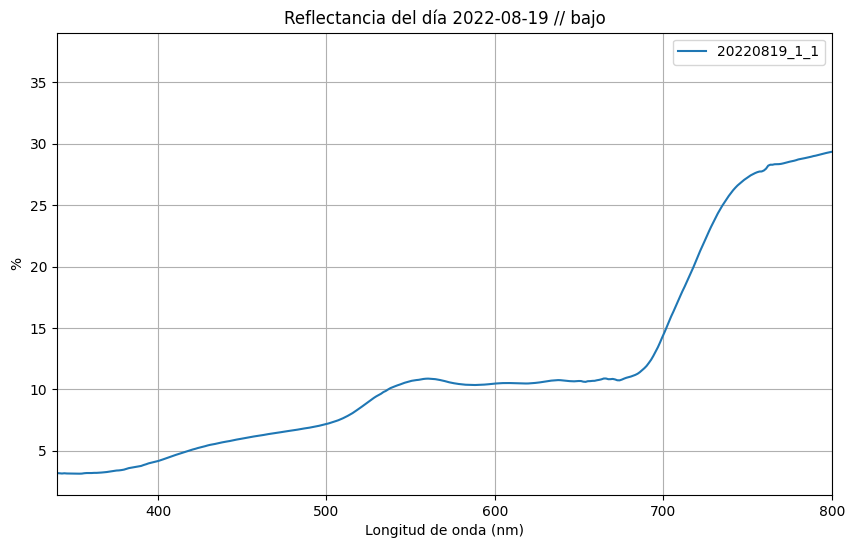

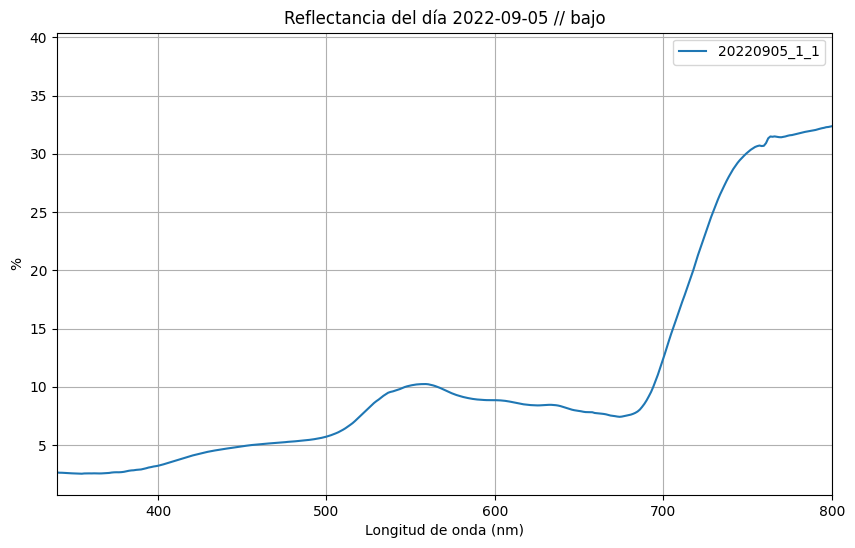

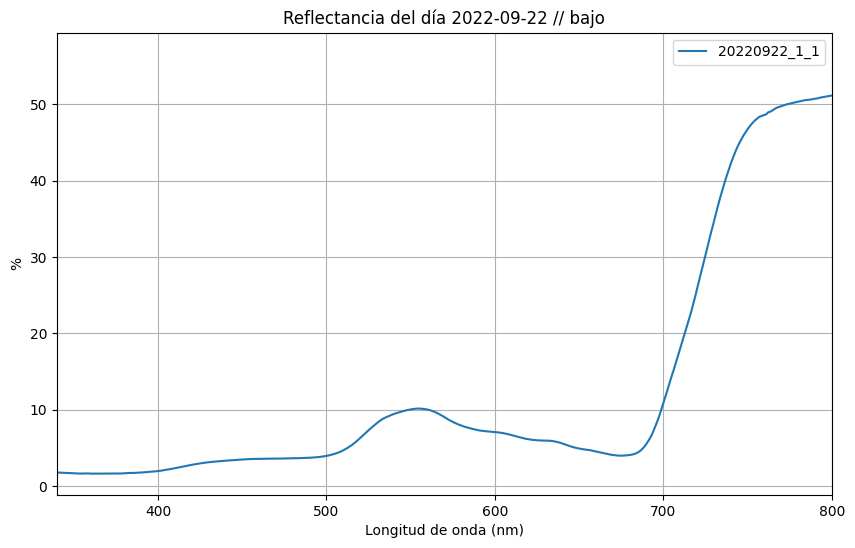

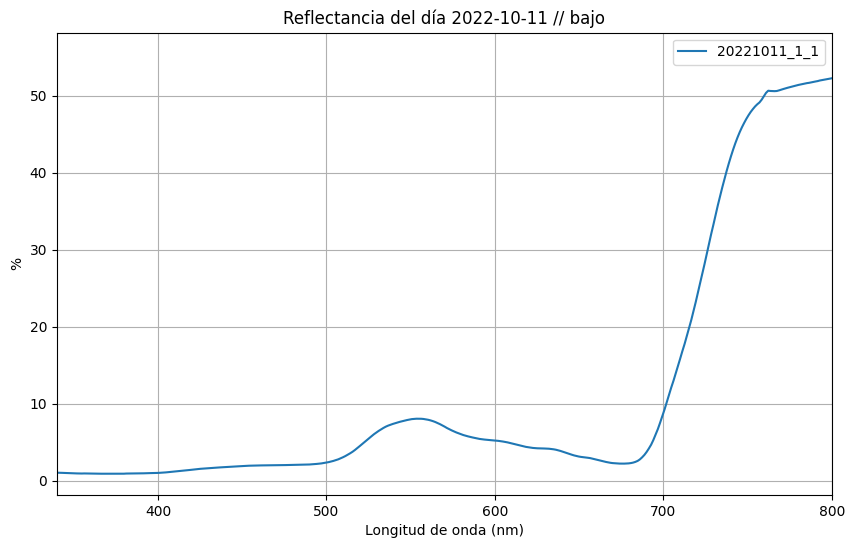

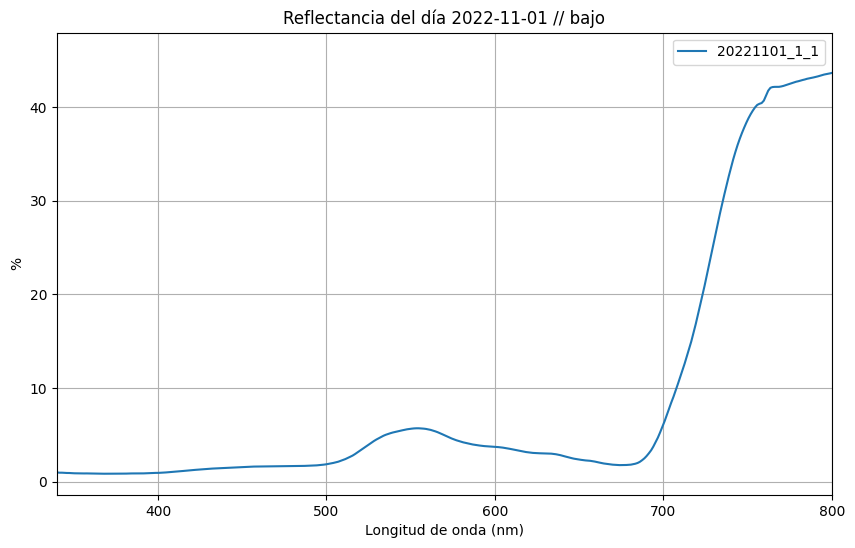

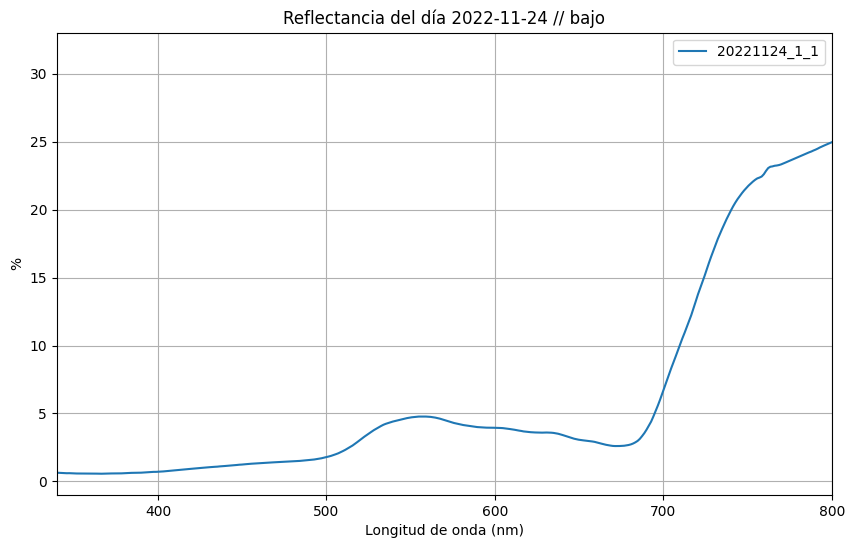

In [11]:
# Seteo las firmas que quiero plotear
num_zona = 1
distancia = 1
plot = 'ref' # rad = radiancias, ref = reflectancias, defoult = radiancias
x_lim = (340,800)

plot_firmas(firmas_fecha= firmas_fecha, zona= num_zona, distancia= distancia, plot= plot, x_lim = x_lim)